<a href="https://www.kaggle.com/code/brmil07/food-industry-stock-price-forecasting-lstm?scriptVersionId=164002919" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Food Industry Stock Price Forecasting 🏭**
---

# **Preparation Phase 🧺**
---

## **Import the Library 📚**
---

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indf-stock-price/Stock_Price_INDF.JK_2001-2023.csv


In [2]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from tqdm import tqdm
from scipy.stats import linregress

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, BatchNormalization
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

2024-02-23 13:15:34.501973: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 13:15:34.502080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 13:15:34.779810: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Load the Data 📔**
---

In [3]:
df = pd.read_csv('/kaggle/input/indf-stock-price/Stock_Price_INDF.JK_2001-2023.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5745 entries, 0 to 5744
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5745 non-null   object 
 1   Open       5743 non-null   float64
 2   High       5743 non-null   float64
 3   Low        5743 non-null   float64
 4   Close      5743 non-null   float64
 5   Adj Close  5743 non-null   float64
 6   Volume     5743 non-null   float64
dtypes: float64(6), object(1)
memory usage: 314.3+ KB


In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-01,775.0,775.0,775.0,775.0,407.255463,0.0
1,2001-01-02,775.0,800.0,775.0,800.0,420.392609,5711000.0
2,2001-01-03,775.0,800.0,775.0,800.0,420.392609,6436500.0
3,2001-01-04,775.0,800.0,775.0,800.0,420.392609,8533500.0
4,2001-01-05,800.0,825.0,775.0,800.0,420.392609,20578000.0


In [6]:
# Check for missing values
df.isna().sum()

Date         0
Open         2
High         2
Low          2
Close        2
Adj Close    2
Volume       2
dtype: int64

In [7]:
# Locate NaN values in the 'Price' column
nan_rows = df[df['Volume'].isna()]
print(nan_rows)

            Date  Open  High  Low  Close  Adj Close  Volume
1983  2008-10-13   NaN   NaN  NaN    NaN        NaN     NaN
4634  2019-06-19   NaN   NaN  NaN    NaN        NaN     NaN


In [8]:
# Drop rows with any null values
df.dropna(inplace=True)

In [9]:
nan_rows = df[df['Volume'].isna()]
print(nan_rows)

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
Index: []


In [10]:
df1 = df[['Date','Adj Close']].copy(deep=True)
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date',inplace = True)
df1.rename(columns={'Adj Close': 'Price'}, inplace=True)
df1 = df1.resample('W').mean()
df1.ffill(inplace=True)

In [11]:
# Check for missing values
df1.isna().sum()

Price    0
dtype: int64

In [12]:
# Check for infinite values
inf_values = df1.isin([np.inf, -np.inf])

# Check if any value is infinite in the DataFrame
if inf_values.any().any():
    print("DataFrame contains infinite values.")
    print("Locations of infinite values:")
    print(inf_values)
else:
    print("DataFrame does not contain infinite values.")

DataFrame does not contain infinite values.


In [13]:
df1[:10].style.background_gradient(cmap='viridis')

,Price
Date,
2001-01-07 00:00:00,417.765180
2001-01-14 00:00:00,420.392609
2001-01-21 00:00:00,425.647504
2001-01-28 00:00:00,441.412225
2001-02-04 00:00:00,491.333826
2001-02-11 00:00:00,551.765271
2001-02-18 00:00:00,530.745630
2001-02-25 00:00:00,530.745630
2001-03-04 00:00:00,491.333844


# **Exploratory Data Analysis 🔍**
---

In [14]:
window_size = 30
ma = df1['Price'].rolling(window=window_size).mean()
mstd = df1['Price'].rolling(window=window_size).std()
slope, intercept, _, _, _ = linregress(np.arange(len(df1)), df1['Price'])

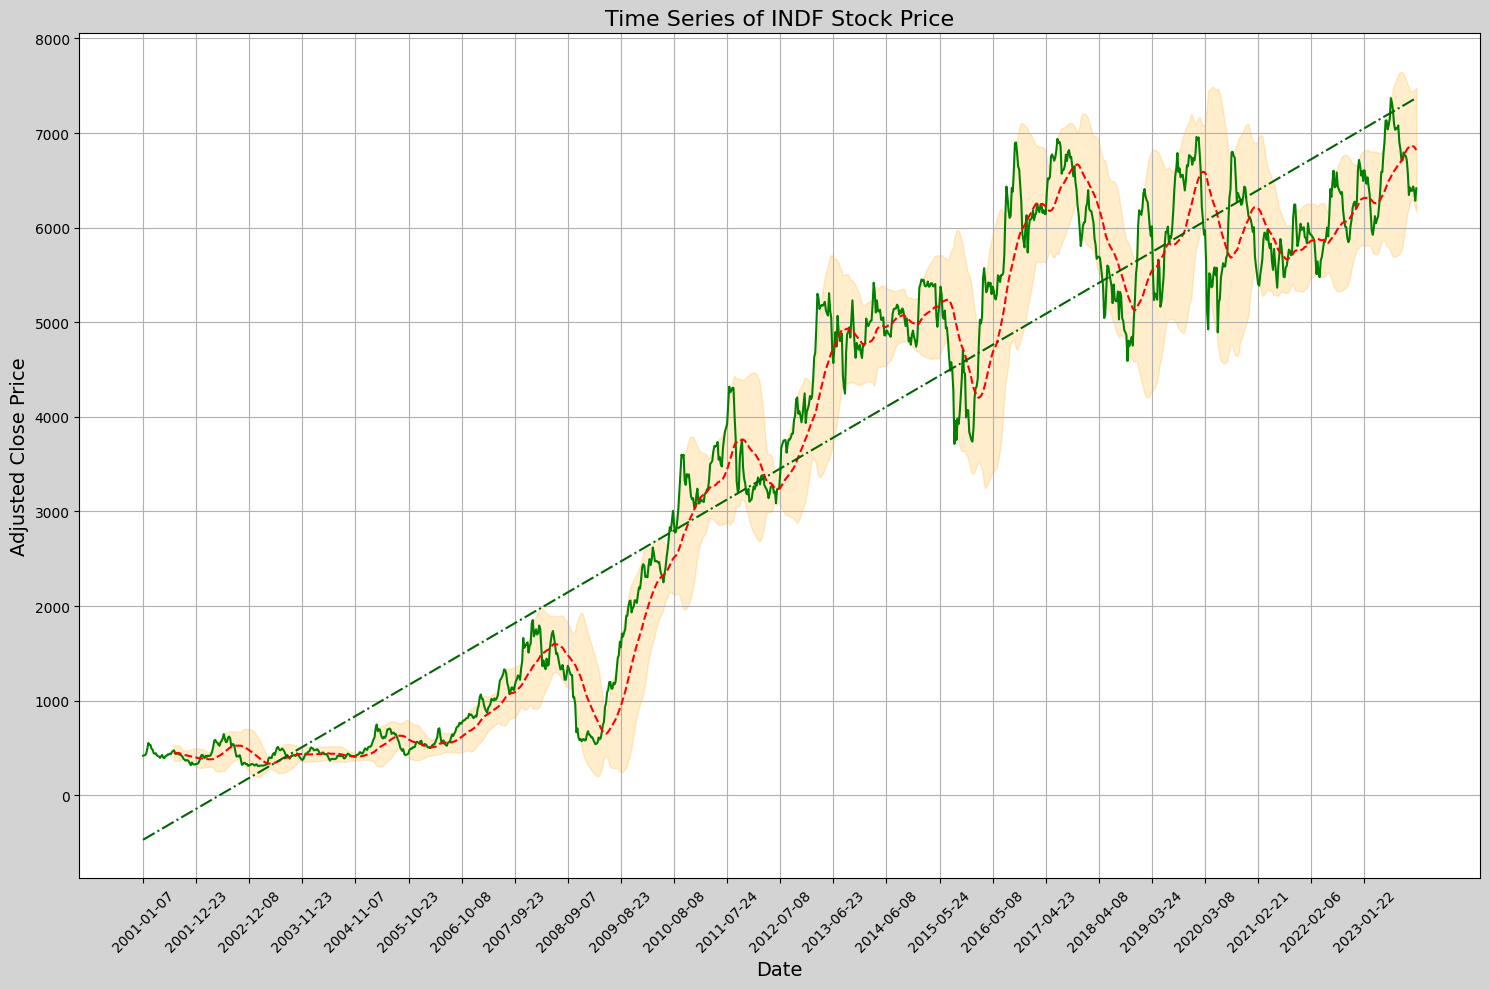

In [15]:
plt.figure(figsize=(15, 10), facecolor='lightgrey')
plt.plot(df1.index, df1['Price'], color='green')
plt.plot(df1.index, ma, label=f'{window_size}-day MA', linestyle='--', color='red')
plt.fill_between(df1.index, ma - 2 * mstd, ma + 2 * mstd, alpha=0.2, label=f'{window_size}-day MSTD', color='orange') 
plt.plot(df1.index, intercept + slope * np.arange(len(df1)), label='Linear Fit', linestyle='-.', color='darkgreen')

n = 50
plt.xticks(df1.index[::n])
plt.xticks(rotation=45)

plt.title("Time Series of INDF Stock Price", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Adjusted Close Price", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# **Stationarity Test 🔬**
---

In [16]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,8))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(15, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

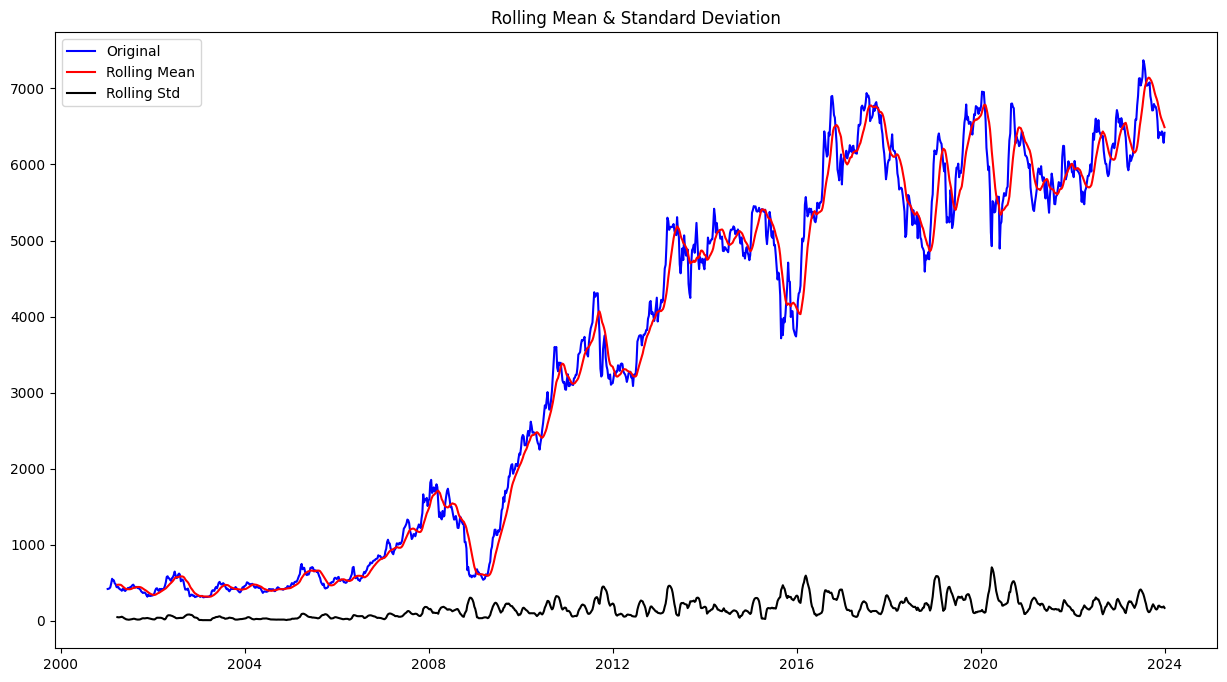

Results of Dickey-Fuller Test:
Test Statistic                   -1.001094
p-value                           0.752865
#Lags Used                        1.000000
Number of Observations Used    1198.000000
Critical Value (1%)              -3.435820
Critical Value (5%)              -2.863956
Critical Value (10%)             -2.568056
dtype: float64


In [17]:
test_stationarity(df1['Price'])

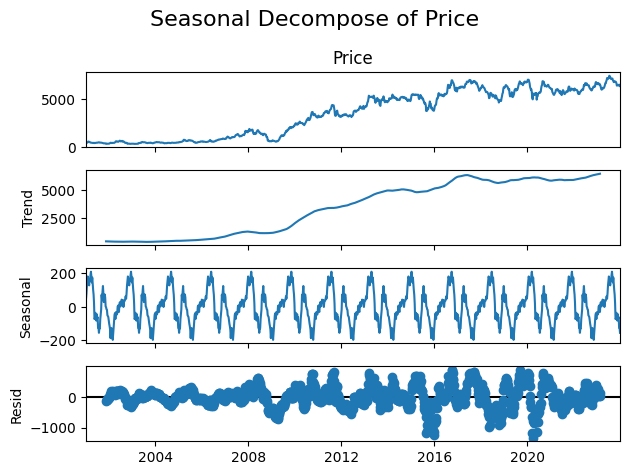

In [18]:
dec = sm.tsa.seasonal_decompose(df1['Price'], period=90).plot()

plt.suptitle('Seasonal Decompose of Price', fontsize=16)
plt.tight_layout()
plt.show()

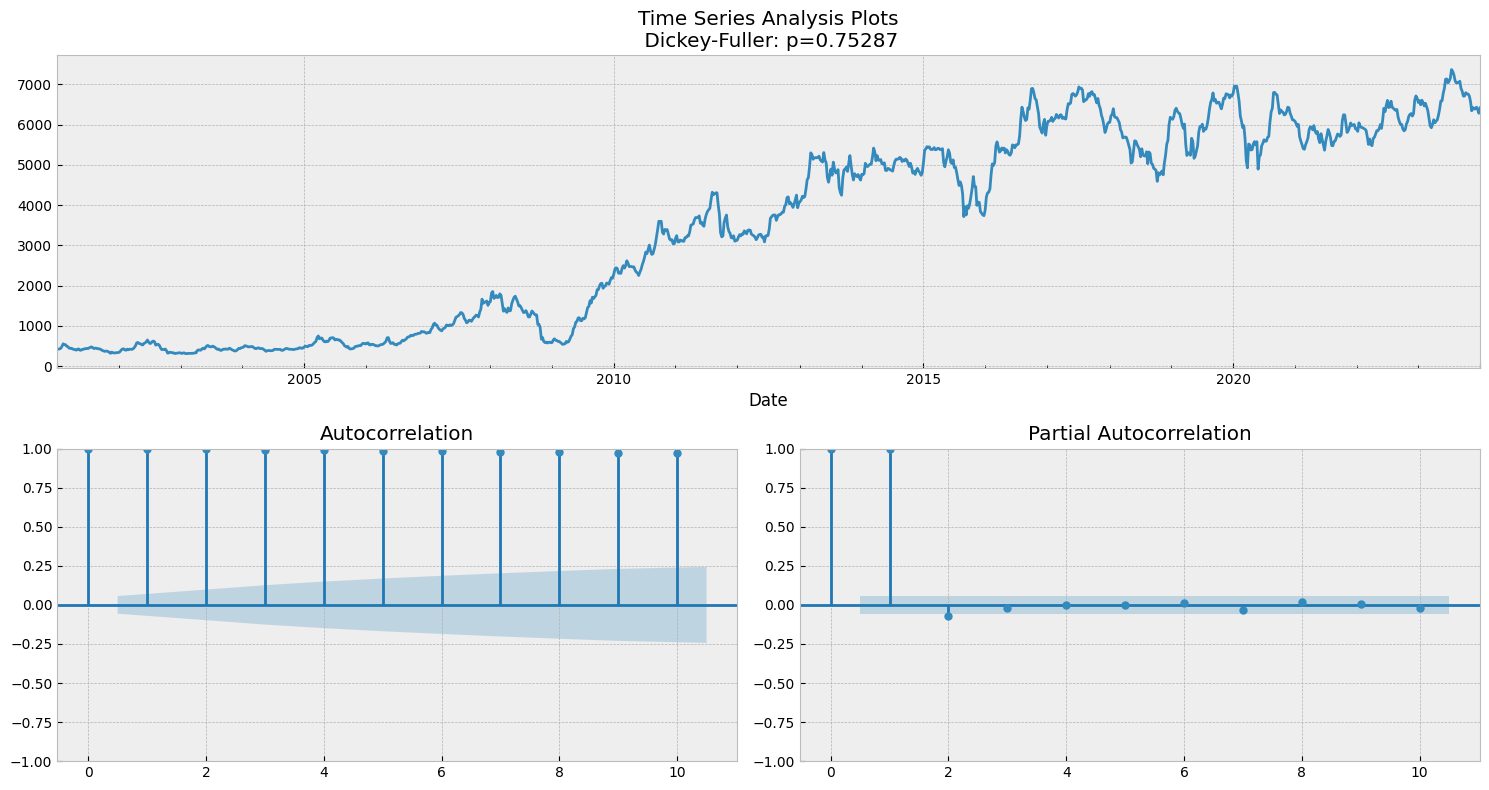

In [19]:
tsplot(df1['Price'], lags = 10)

A **p-value** of **0.75287** from Dickey-Fuller Test indicates that the data is likely not stationary. For time series forecasting with stock price data, it is crucial to make the data stationary before feeding it into a machine learning model.

# **Data Augmentation ✂️**
---

In [20]:
df2 = df1.copy()
df2.head()

,Price
Date,
2001-01-07,417.765180
2001-01-14,420.392609
2001-01-21,425.647504
2001-01-28,441.412225
2001-02-04,491.333826


In [21]:
df2['Price_Diff'] = df2['Price'].diff()
df2['Price_Log'] = np.log(df2['Price'])
df2['Price_Detrended'] = df2['Price'] - df2['Price'].rolling(window=30).mean() 
result_sd = seasonal_decompose(df2['Price'], model='multiplicative', period=52)
df2['Price_Seasonal_Adjusted'] = df2['Price'] - result_sd.seasonal
window_size = 30
df2['Price_Rolling_Mean'] = df2['Price'].rolling(window=window_size).mean()
df2['Price_Rolling_Std'] = df2['Price'].rolling(window=window_size).std()
df2.head()

,Price,Price_Diff,Price_Log,Price_Detrended,Price_Seasonal_Adjusted,Price_Rolling_Mean,Price_Rolling_Std
Date,,,,,,,
2001-01-07,417.765180,NaN,6.034920,NaN,416.810057,NaN,NaN
2001-01-14,420.392609,2.627429,6.041189,NaN,419.423902,NaN,NaN
2001-01-21,425.647504,5.254895,6.053612,NaN,424.650830,NaN,NaN
2001-01-28,441.412225,15.764722,6.089979,NaN,440.407945,NaN,NaN
2001-02-04,491.333826,49.921600,6.197124,NaN,490.334087,NaN,NaN


In [22]:
df2.isna().sum()

Price                       0
Price_Diff                  1
Price_Log                   0
Price_Detrended            29
Price_Seasonal_Adjusted     0
Price_Rolling_Mean         29
Price_Rolling_Std          29
dtype: int64

In [23]:
df2.dropna(inplace=True)
df2.head()

,Price,Price_Diff,Price_Log,Price_Detrended,Price_Seasonal_Adjusted,Price_Rolling_Mean,Price_Rolling_Std
Date,,,,,,,
2001-07-29,474.827075,8.047882,6.162951,30.538451,473.785917,444.288625,41.293597
2001-08-05,453.366016,-21.461060,6.116700,7.890697,452.324437,445.475319,41.015696
2001-08-12,434.587580,-18.778436,6.074397,-11.360905,433.555004,445.948485,40.797657
2001-08-19,445.318116,10.730536,6.098789,-1.286056,444.288703,446.604172,40.617809
2001-08-26,442.635468,-2.682648,6.092747,-4.009479,441.617135,446.644947,40.613031


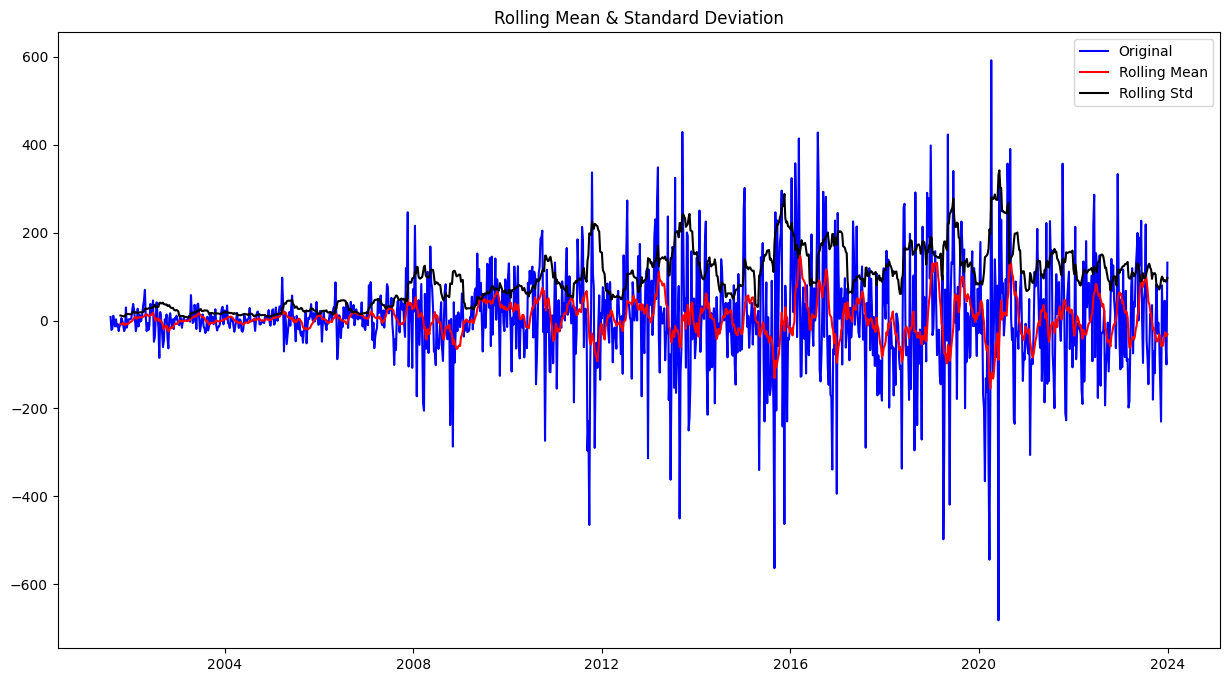

Results of Dickey-Fuller Test:
Test Statistic                  -28.709936
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1170.000000
Critical Value (1%)              -3.435951
Critical Value (5%)              -2.864013
Critical Value (10%)             -2.568087
dtype: float64


In [24]:
test_stationarity(df2['Price_Diff'])

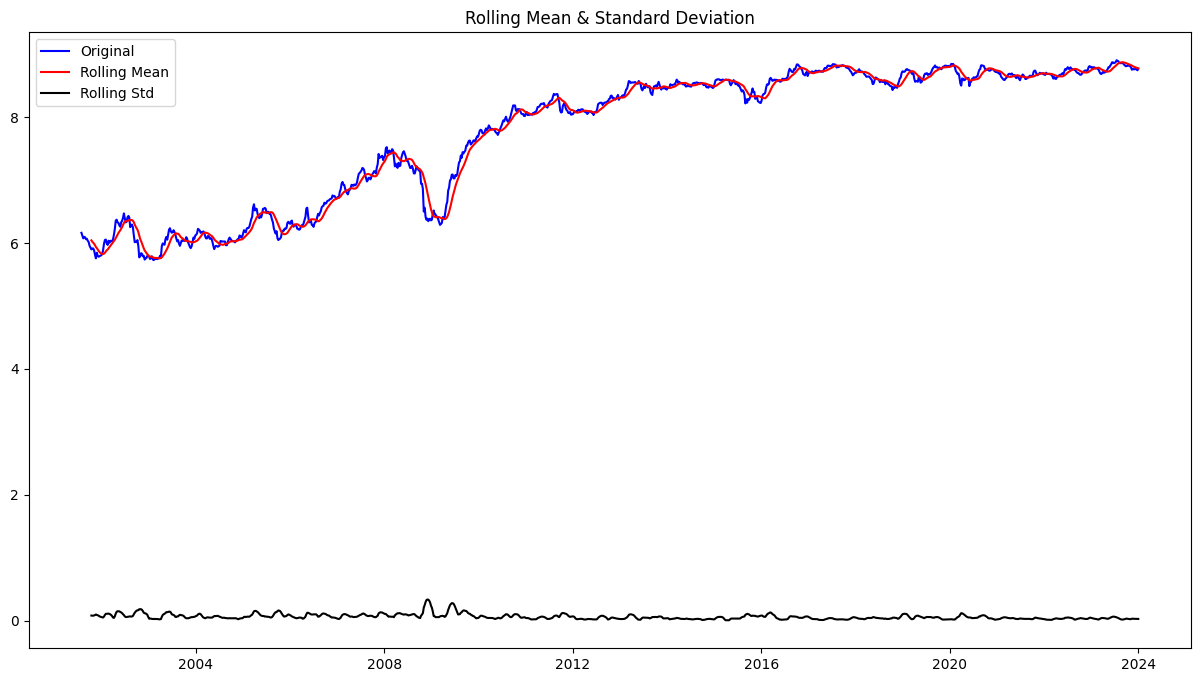

Results of Dickey-Fuller Test:
Test Statistic                   -1.320631
p-value                           0.619681
#Lags Used                        3.000000
Number of Observations Used    1167.000000
Critical Value (1%)              -3.435966
Critical Value (5%)              -2.864020
Critical Value (10%)             -2.568090
dtype: float64


In [25]:
test_stationarity(df2['Price_Log'])

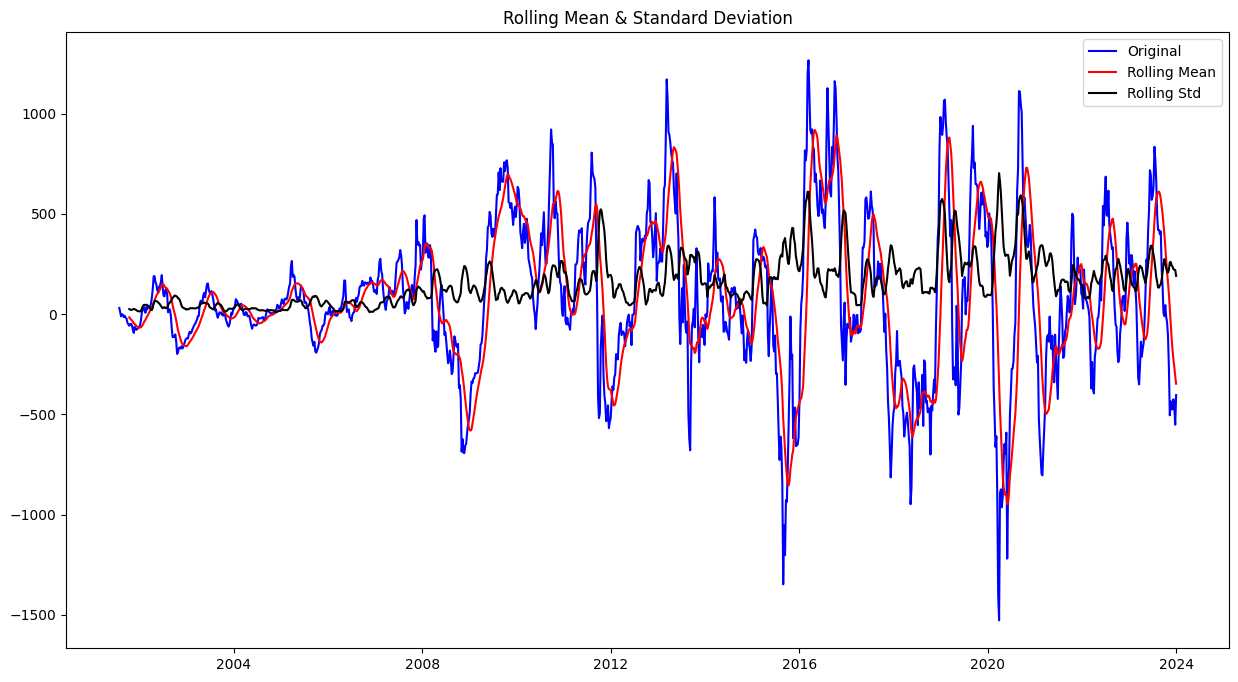

Results of Dickey-Fuller Test:
Test Statistic                -7.342239e+00
p-value                        1.057763e-10
#Lags Used                     9.000000e+00
Number of Observations Used    1.161000e+03
Critical Value (1%)           -3.435995e+00
Critical Value (5%)           -2.864033e+00
Critical Value (10%)          -2.568097e+00
dtype: float64


In [26]:
test_stationarity(df2['Price_Detrended'])

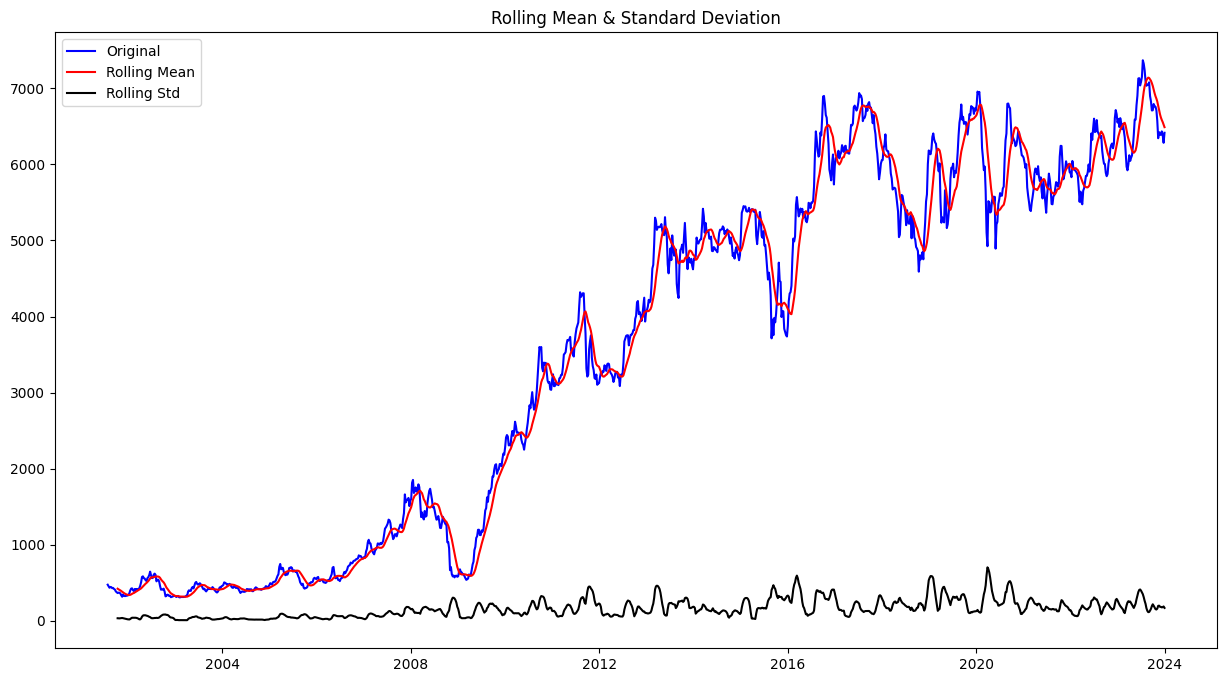

Results of Dickey-Fuller Test:
Test Statistic                   -1.040924
p-value                           0.738047
#Lags Used                        1.000000
Number of Observations Used    1169.000000
Critical Value (1%)              -3.435956
Critical Value (5%)              -2.864016
Critical Value (10%)             -2.568088
dtype: float64


In [27]:
test_stationarity(df2['Price_Seasonal_Adjusted'])

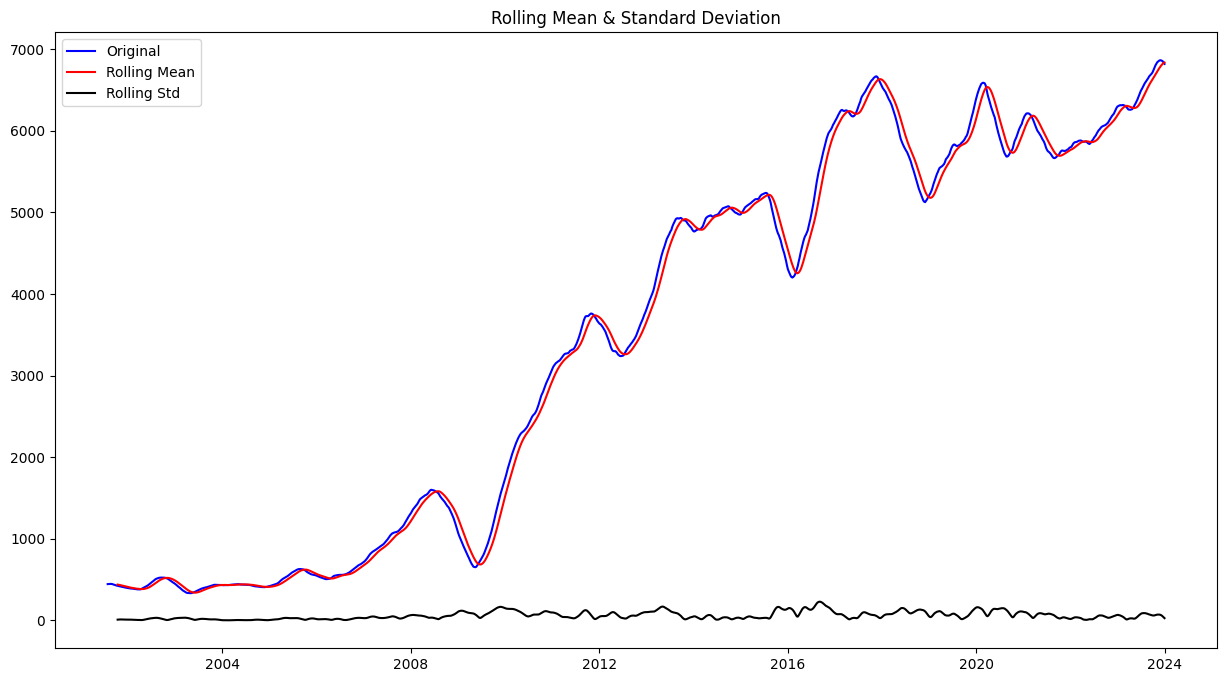

Results of Dickey-Fuller Test:
Test Statistic                   -0.846744
p-value                           0.805004
#Lags Used                        7.000000
Number of Observations Used    1163.000000
Critical Value (1%)              -3.435985
Critical Value (5%)              -2.864028
Critical Value (10%)             -2.568095
dtype: float64


In [28]:
test_stationarity(df2['Price_Rolling_Mean'])

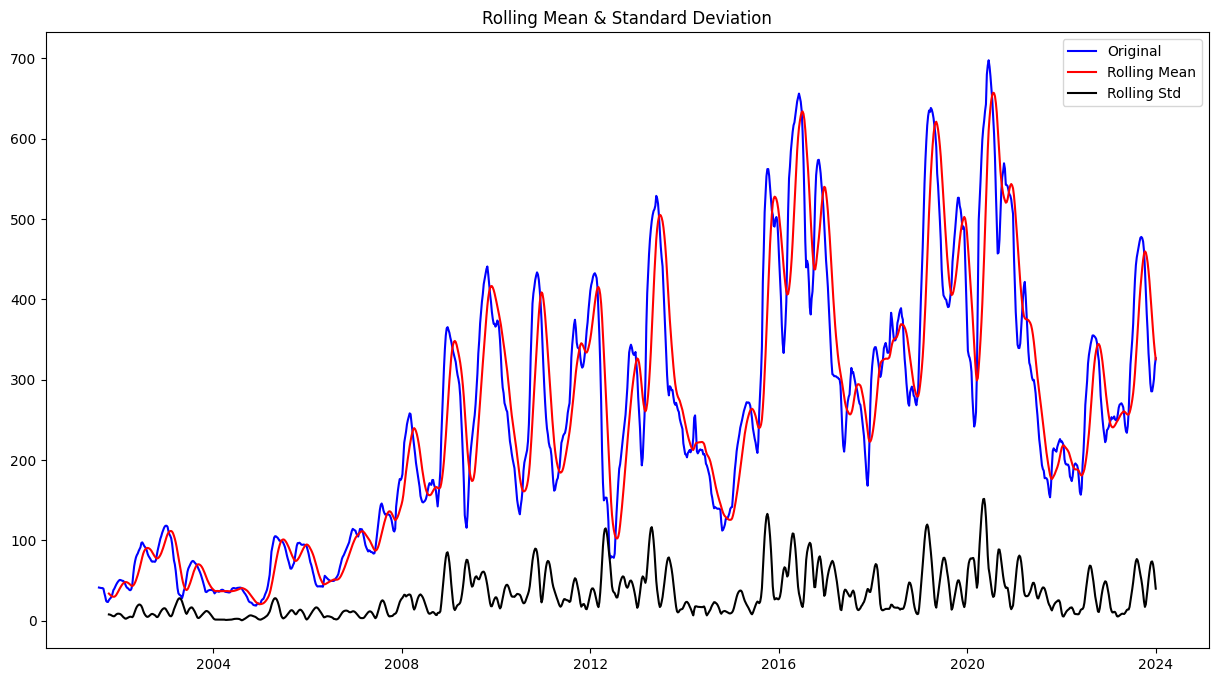

Results of Dickey-Fuller Test:
Test Statistic                   -2.434574
p-value                           0.132215
#Lags Used                       22.000000
Number of Observations Used    1148.000000
Critical Value (1%)              -3.436059
Critical Value (5%)              -2.864061
Critical Value (10%)             -2.568112
dtype: float64


In [29]:
test_stationarity(df2['Price_Rolling_Std'])

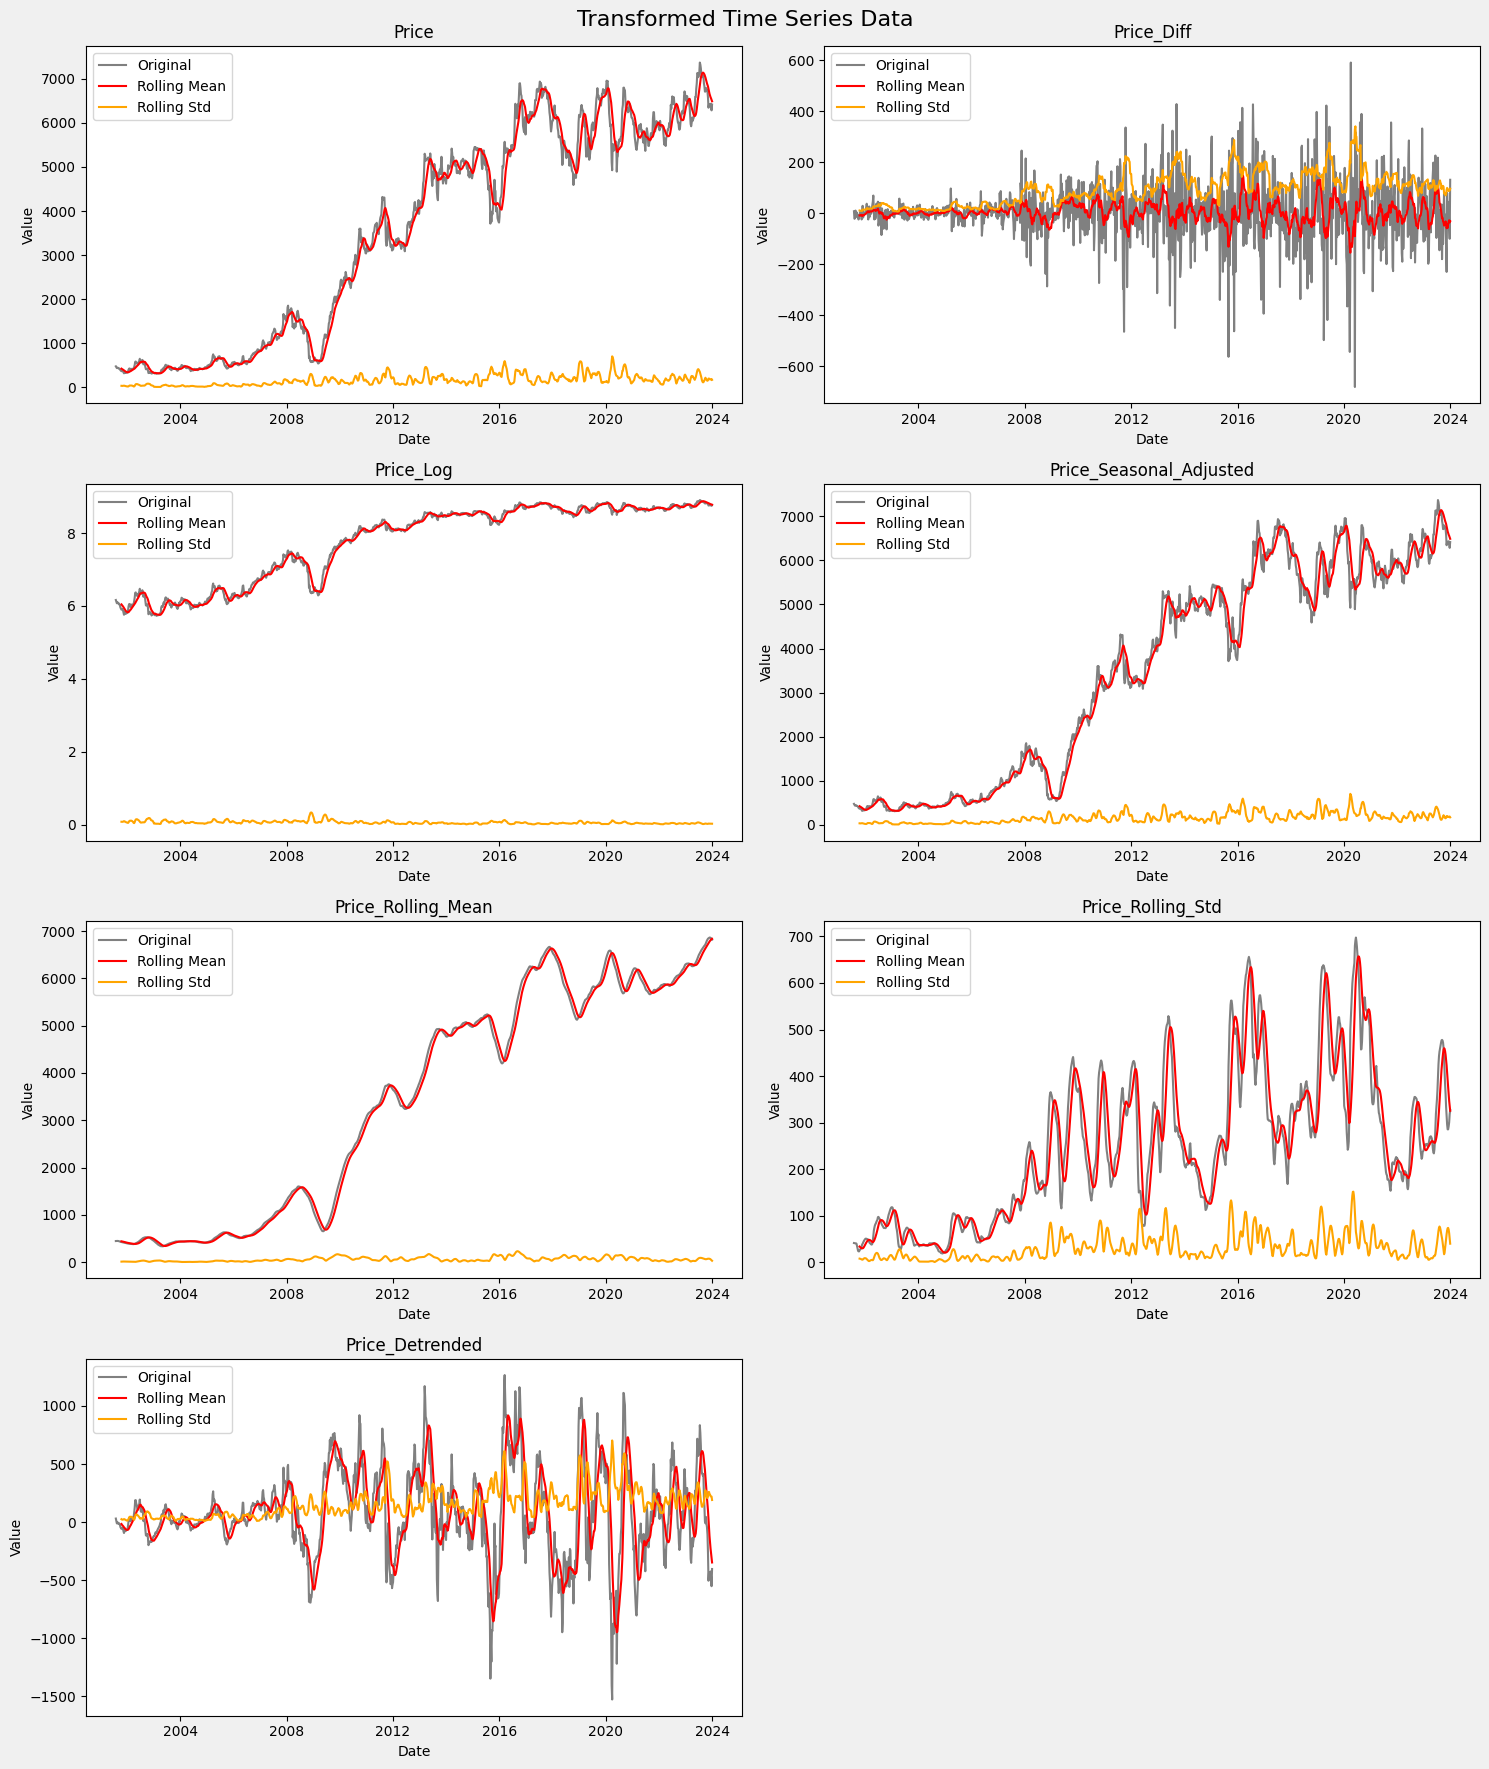

In [30]:
fig, axes = plt.subplots(4, 2, figsize=(15, 18), facecolor='#f0f0f0')

# Flatten the axes
axes = axes.flatten()

# List of columns to plot
columns_to_plot = ['Price', 'Price_Diff', 'Price_Log', 'Price_Seasonal_Adjusted', 'Price_Rolling_Mean', 'Price_Rolling_Std', 'Price_Detrended']

# Plot each column
for i, col in enumerate(columns_to_plot):
    ax = axes[i]
    ax.plot(df2.index, df2[col], label='Original', color='grey')

    # Calculate rolling statistics
    MA = df2[col].rolling(window=12).mean()
    MSTD = df2[col].rolling(window=12).std()

    ax.plot(df2.index, MA, color='red', label='Rolling Mean')
    ax.plot(df2.index, MSTD, color='orange', label='Rolling Std')

    ax.set_title(col)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()

# Hide any unused subplots
for i in range(len(columns_to_plot), 4 * 2):
    fig.delaxes(axes[i])

plt.suptitle("Transformed Time Series Data", size=16)
plt.tight_layout()
plt.show()

# **Data Preprocessing ⚙️**
---

In [31]:
# Define look back (sequence length)
look_back = 90

# Split dataframe into train and test set
train_data, test_data = train_test_split(df1, test_size=0.2, shuffle=False)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

# Create input-output pairs for training
X_train, Y_train = [], []
for i in range(len(scaled_train_data) - look_back):
    X_train.append(scaled_train_data[i:(i + look_back), 0])
    Y_train.append(scaled_train_data[i + look_back, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshape input data for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

# Create input-output pairs for testing
X_test, Y_test = [], []
for i in range(len(scaled_test_data) - look_back):
    X_test.append(scaled_test_data[i:(i + look_back), 0])
    Y_test.append(scaled_test_data[i + look_back, 0])

X_test, Y_test = np.array(X_test), np.array(Y_test)

# Reshape input data for LSTM (samples, time steps, features)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# **Model Building 🏗️**
---

In [32]:
epochs = 20
dropout_rate = 0.1
l1_reg = 0.01 
l2_reg = 0.01

# Define model architecture
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back), return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(LSTM(64))
model.add(Dropout(dropout_rate))
model.add(Dense(1))
model.add(BatchNormalization())

# Compile model
optimizer = RMSprop(lr=0.00015)  # Adjust learning rate as needed
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Learning rate scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [33]:
# Train the model
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=5, verbose=2, validation_data=(X_test, Y_test), callbacks=[reduce_lr])

Epoch 1/20


I0000 00:00:1708694170.783402      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


174/174 - 7s - loss: 0.1573 - val_loss: 0.4480 - lr: 0.0010 - 7s/epoch - 42ms/step
Epoch 2/20
174/174 - 1s - loss: 0.0618 - val_loss: 0.2228 - lr: 0.0010 - 778ms/epoch - 4ms/step
Epoch 3/20
174/174 - 1s - loss: 0.0318 - val_loss: 0.1374 - lr: 0.0010 - 800ms/epoch - 5ms/step
Epoch 4/20
174/174 - 1s - loss: 0.0262 - val_loss: 0.0335 - lr: 0.0010 - 836ms/epoch - 5ms/step
Epoch 5/20
174/174 - 1s - loss: 0.0271 - val_loss: 0.0118 - lr: 0.0010 - 792ms/epoch - 5ms/step
Epoch 6/20
174/174 - 1s - loss: 0.0240 - val_loss: 0.0077 - lr: 0.0010 - 785ms/epoch - 5ms/step
Epoch 7/20
174/174 - 1s - loss: 0.0209 - val_loss: 0.0219 - lr: 0.0010 - 785ms/epoch - 5ms/step
Epoch 8/20
174/174 - 1s - loss: 0.0183 - val_loss: 0.0013 - lr: 0.0010 - 789ms/epoch - 5ms/step
Epoch 9/20
174/174 - 1s - loss: 0.0216 - val_loss: 0.0067 - lr: 0.0010 - 785ms/epoch - 5ms/step
Epoch 10/20
174/174 - 1s - loss: 0.0217 - val_loss: 0.0016 - lr: 0.0010 - 774ms/epoch - 4ms/step
Epoch 11/20
174/174 - 1s - loss: 0.0228 - val_loss: 

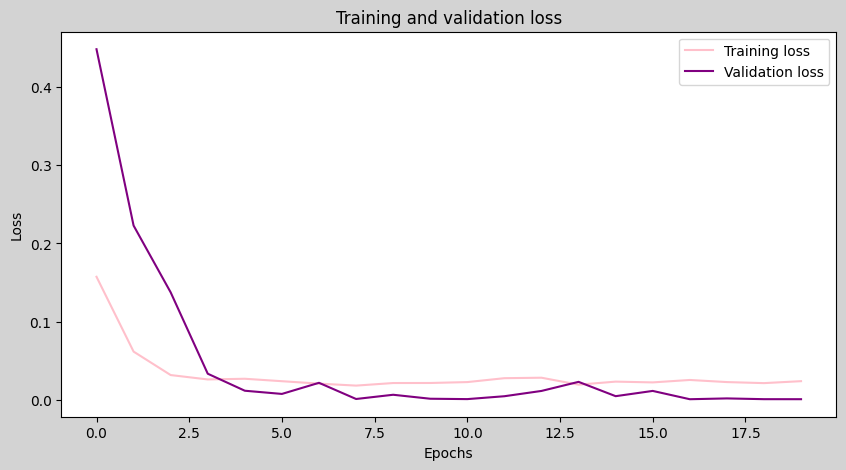

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(10,5), facecolor='lightgrey')
plt.plot(loss, label='Training loss', color='pink')
plt.plot(val_loss, label='Validation loss', color='purple')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
# Predict for existing data
predictions = model.predict(X_test)
# Inverse transform the predictions
predictions = scaler.inverse_transform(predictions)

5/5 [==============================] - 1s 3ms/step


In [36]:
# Inverse transform the actual data for existing data
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Predict for future days
future_days = 120
future_dates = pd.date_range(start=df1.index[-1] + pd.Timedelta(days=7), periods=future_days, freq='W')
future_predictions = []

# Use the last look_back data points to predict the next point, and then append it to input for next prediction
last_sequence = scaled_test_data[-look_back:, 0]

for i in tqdm(range(future_days)):
    prediction = model.predict(np.reshape(last_sequence, (1, 1, look_back)))
    future_predictions.append(prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = prediction[0, 0]
    
# Inverse transform the predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

  0%|          | 0/120 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 2/120 [00:00<00:09, 12.69it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 4/120 [00:00<00:08, 13.90it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 6/120 [00:00<00:08, 13.68it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 8/120 [00:00<00:08, 13.83it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 10/120 [00:00<00:07, 14.30it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 12/120 [00:00<00:07, 13.70it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 14/120 [00:01<00:07, 13.55it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 16/120 [00:01<00:07, 14.03it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 18/120 [00:01<00:07, 14.53it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 20/120 [00:01<00:06, 14.66it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 22/120 [00:01<00:06, 14.94it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 24/120 [00:01<00:06, 15.10it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 26/120 [00:01<00:06, 15.18it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 28/120 [00:01<00:05, 15.35it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 30/120 [00:02<00:06, 14.86it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 32/120 [00:02<00:05, 15.29it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 34/120 [00:02<00:05, 15.36it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 36/120 [00:02<00:05, 15.18it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 38/120 [00:02<00:05, 15.29it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 40/120 [00:02<00:05, 15.52it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 42/120 [00:02<00:05, 14.94it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 44/120 [00:03<00:05, 14.44it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 46/120 [00:03<00:05, 14.02it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 48/120 [00:03<00:05, 13.20it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 50/120 [00:03<00:05, 13.54it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 52/120 [00:03<00:04, 13.83it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 54/120 [00:03<00:04, 13.96it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 56/120 [00:03<00:04, 14.11it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 58/120 [00:04<00:04, 14.16it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 60/120 [00:04<00:04, 14.68it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 62/120 [00:04<00:03, 14.89it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 64/120 [00:04<00:03, 14.96it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 66/120 [00:04<00:03, 14.90it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 68/120 [00:04<00:03, 14.99it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 70/120 [00:04<00:03, 14.93it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 72/120 [00:04<00:03, 14.98it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 74/120 [00:05<00:03, 14.73it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 76/120 [00:05<00:03, 14.25it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 78/120 [00:05<00:02, 14.34it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 80/120 [00:05<00:02, 14.52it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 82/120 [00:05<00:02, 14.92it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 84/120 [00:05<00:02, 14.46it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 86/120 [00:05<00:02, 14.74it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 88/120 [00:06<00:02, 15.05it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 90/120 [00:06<00:01, 15.11it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 92/120 [00:06<00:01, 14.80it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 94/120 [00:06<00:01, 14.96it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 96/120 [00:06<00:01, 14.91it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 98/120 [00:06<00:01, 14.98it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 100/120 [00:06<00:01, 15.25it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 102/120 [00:06<00:01, 14.93it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 104/120 [00:07<00:01, 14.87it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 106/120 [00:07<00:00, 14.97it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 108/120 [00:07<00:00, 15.08it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 110/120 [00:07<00:00, 15.10it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 112/120 [00:07<00:00, 15.13it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 114/120 [00:07<00:00, 15.21it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 116/120 [00:07<00:00, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 118/120 [00:08<00:00, 15.48it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 120/120 [00:08<00:00, 14.70it/s]


# **Evaluate the Model 🖼️**
---

In [37]:
rmse = np.sqrt(mean_squared_error(Y_test_inv, predictions))
r2 = r2_score(Y_test_inv, predictions)
mae = mean_absolute_error(Y_test_inv, predictions)

print("RMSE of Test Data:", rmse)
print("R-squared of Test Data:", r2)
print("MAE of Test Data:", mae)

RMSE of Test Data: 207.90273693857512
R-squared of Test Data: 0.8044378516080589
MAE of Test Data: 168.62378773679166


In [38]:
prediction_std = np.std(future_predictions)
mse = np.mean(np.square(future_predictions - np.mean(future_predictions)))
rmse = np.sqrt(mse)
upper_bound = np.percentile(future_predictions, 97.5)
lower_bound = np.percentile(future_predictions, 2.5)
ci_width = upper_bound - lower_bound

print("Standard Deviation of Future Predictions:", prediction_std)
print("Mean Squared Error of Future Predictions:", mse)
print("Root Mean Squared Error of Future Predictions:", rmse)
print("Confidence Interval Width of Future Predictions:", ci_width)

Standard Deviation of Future Predictions: 116.61487
Mean Squared Error of Future Predictions: 13599.027
Root Mean Squared Error of Future Predictions: 116.61487
Confidence Interval Width of Future Predictions: 406.49681396484357


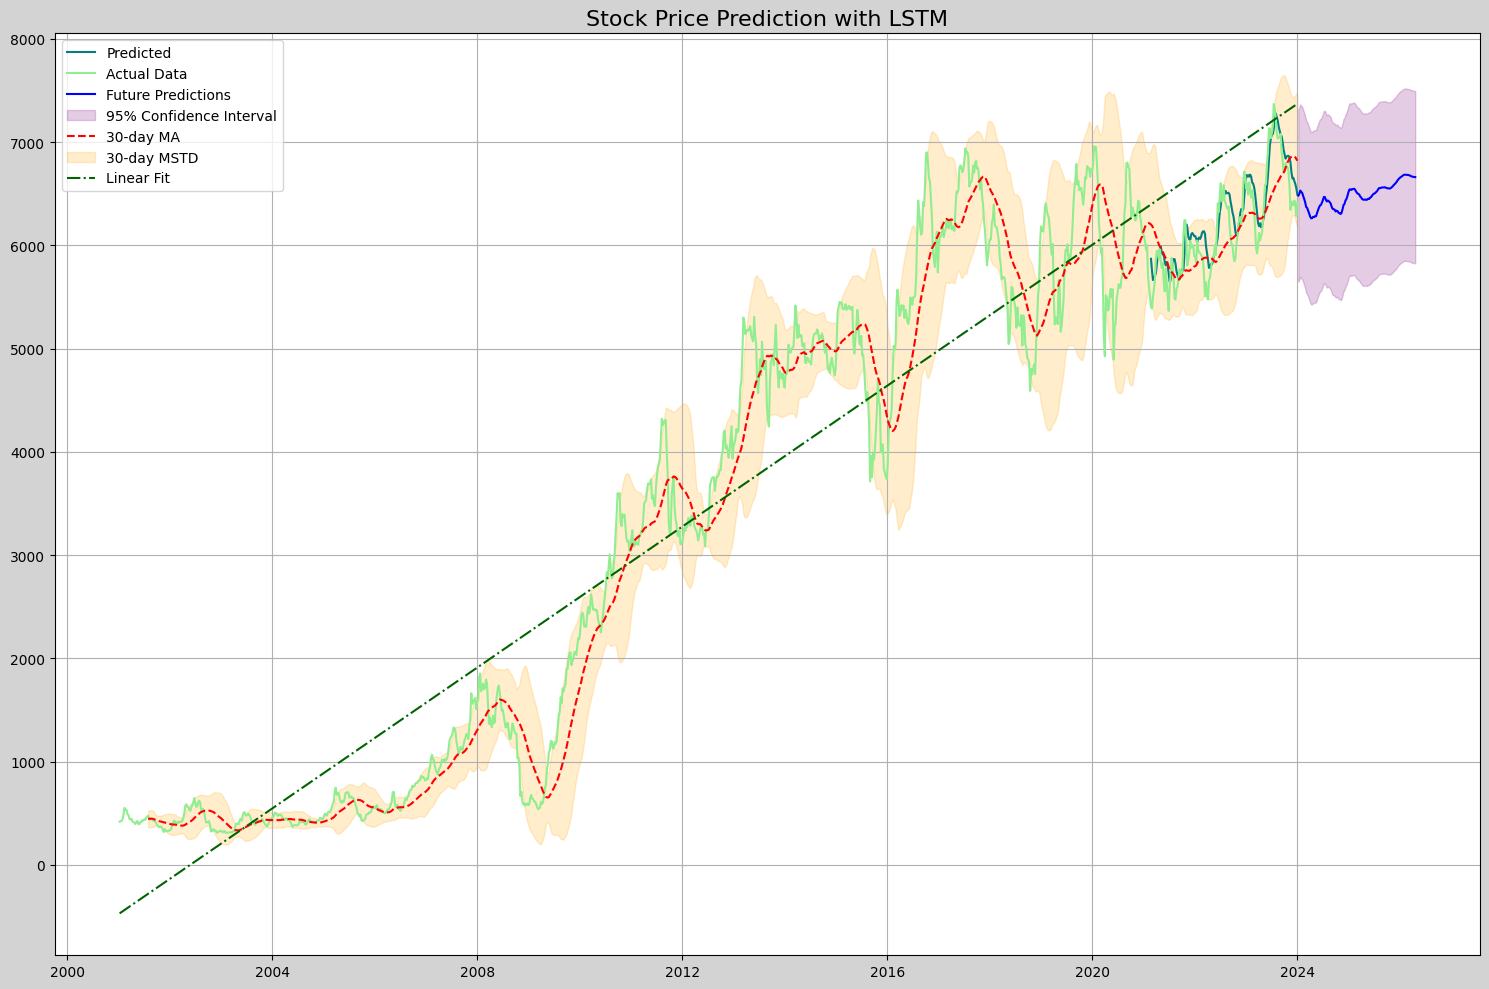

In [39]:
# Compute standard deviation of the predictions
prediction_std = np.std(predictions)

# Plot the predictions
fig = plt.figure(figsize=(15, 10), facecolor='lightgrey')

plt.plot(df1.index[-len(predictions):], predictions, label='Predicted', color='teal')
plt.plot(df1.index, df1['Price'], label='Actual Data', color='lightgreen')

plt.plot(future_dates, future_predictions, label='Future Predictions', color='blue')
# 95% confidence interval
confidence_interval_upper = future_predictions.flatten() + 1.96 * prediction_std  
confidence_interval_lower = future_predictions.flatten() - 1.96 * prediction_std  
plt.fill_between(future_dates, confidence_interval_lower, confidence_interval_upper, color='purple', alpha=0.2, label='95% Confidence Interval')

plt.plot(df1.index, ma, label=f'{window_size}-day MA', linestyle='--', color='red')
plt.fill_between(df1.index, ma - 2 * mstd, ma + 2 * mstd, alpha=0.2, label=f'{window_size}-day MSTD', color='orange') 
plt.plot(df1.index, intercept + slope * np.arange(len(df1)), label='Linear Fit', linestyle='-.', color='darkgreen')

plt.legend(loc='best')
plt.title('Stock Price Prediction with LSTM', size=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# **References 📃**
---
* [Bank Stock Price Forecasting](https://www.kaggle.com/code/brmil07/bank-stock-price-forecasting)